In [ ]:
# ! pip install scikit-learn nltk wordcloud

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk import ngrams, ne_chunk, pos_tag
from wordcloud import WordCloud
from IPython.display import display, HTML

import nltk
import ssl

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

# Download all required NLTK resources

print("Downloading required NLTK resources...")
try:
    nltk.download('popular')
    print("Successfully downloaded popular packages")
except Exception as e:
    print(f"Error downloading popular packages: {e}")
    
resources = [
    'punkt', 'punkt_tab', 'stopwords', 'wordnet', 'averaged_perceptron_tagger','averaged_perceptron_tagger_eng','maxent_ne_chunker_tab',
    'maxent_ne_chunker', 'words', 'omw-1.4'
]



for resource in resources:
    try:
        nltk.download(resource, quiet=True)
        print(f"Successfully downloaded {resource}")
    except Exception as e:
        print(f"Error downloading {resource}: {e}")
        
print("NLTK resource download complete.")


# First, generate the dataset using the provided code
import random
from sklearn.datasets import fetch_20newsgroups

# Set random seed for reproducibility
np.random.seed(42)
random.seed(42)

[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to
[nltk_data]    |     /Users/raamraam/nltk_data...
[nltk_data]    |   Package cmudict is already up-to-date!
[nltk_data]    | Downloading package gazetteers to
[nltk_data]    |     /Users/raamraam/nltk_data...
[nltk_data]    |   Package gazetteers is already up-to-date!
[nltk_data]    | Downloading package genesis to
[nltk_data]    |     /Users/raamraam/nltk_data...
[nltk_data]    |   Package genesis is already up-to-date!
[nltk_data]    | Downloading package gutenberg to
[nltk_data]    |     /Users/raamraam/nltk_data...
[nltk_data]    |   Package gutenberg is already up-to-date!
[nltk_data]    | Downloading package inaugural to
[nltk_data]    |     /Users/raamraam/nltk_data...
[nltk_data]    |   Package inaugural is already up-to-date!
[nltk_data]    | Downloading package movie_reviews to
[nltk_data]    |     /Users/raamraam/nltk_data...
[nltk_data]    |   Unzipping corpora/mo

Successfully downloaded popular packages
Successfully downloaded punkt
Successfully downloaded punkt_tab
Successfully downloaded stopwords
Successfully downloaded wordnet
Successfully downloaded averaged_perceptron_tagger
Successfully downloaded averaged_perceptron_tagger_eng
Successfully downloaded maxent_ne_chunker_tab
Successfully downloaded maxent_ne_chunker
Successfully downloaded words
Successfully downloaded omw-1.4
NLTK resource download complete.


[nltk_data]    |   Package maxent_ne_chunker is already up-to-date!
[nltk_data]    | Downloading package punkt to
[nltk_data]    |     /Users/raamraam/nltk_data...
[nltk_data]    |   Package punkt is already up-to-date!
[nltk_data]    | Downloading package snowball_data to
[nltk_data]    |     /Users/raamraam/nltk_data...
[nltk_data]    |   Package snowball_data is already up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /Users/raamraam/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger is already up-
[nltk_data]    |       to-date!
[nltk_data]    | 
[nltk_data]  Done downloading collection popular


In [3]:
# Create positive and negative vocabulary
positive_words = [
    'excellent', 'amazing', 'great', 'good', 'fantastic', 'wonderful', 'brilliant',
    'perfect', 'outstanding', 'superb', 'masterpiece', 'stunning', 'impressive',
    'enjoyable', 'entertaining', 'captivating', 'engaging', 'powerful', 'moving',
    'beautiful', 'compelling', 'memorable', 'remarkable', 'spectacular', 'phenomenal'
]

negative_words = [
    'terrible', 'awful', 'bad', 'poor', 'disappointing', 'boring', 'dull',
    'mediocre', 'waste', 'horrible', 'worst', 'stupid', 'annoying', 'predictable',
    'unbearable', 'ridiculous', 'failure', 'disaster', 'nonsense', 'mess',
    'underwhelming', 'forgettable', 'confusing', 'pointless', 'painful'
]

# Create lists of movie-related named entities for NER task
director_names = [
    'Steven Spielberg', 'Christopher Nolan', 'Martin Scorsese', 'Quentin Tarantino',
    'James Cameron', 'Kathryn Bigelow', 'Alfred Hitchcock', 'Ridley Scott',
    'Greta Gerwig', 'Sofia Coppola', 'Denis Villeneuve', 'Francis Ford Coppola',
    'David Fincher', 'Spike Lee', 'Wes Anderson', 'Ava DuVernay'
]

actor_names = [
    'Tom Hanks', 'Meryl Streep', 'Leonardo DiCaprio', 'Jennifer Lawrence',
    'Denzel Washington', 'Viola Davis', 'Brad Pitt', 'Cate Blanchett',
    'Robert De Niro', 'Kate Winslet', 'Morgan Freeman', 'Scarlett Johansson',
    'Daniel Day-Lewis', 'Emma Stone', 'Samuel L. Jackson', 'Natalie Portman'
]

movie_titles = [
    'The Shawshank Redemption', 'The Godfather', 'Pulp Fiction', 'The Dark Knight',
    'Schindler\'s List', 'Forrest Gump', 'Inception', 'The Matrix',
    'Titanic', 'Avatar', 'Parasite', 'Casablanca',
    'Goodfellas', 'The Silence of the Lambs', 'Jurassic Park', 'Star Wars'
]

award_names = [
    'Oscar', 'Academy Award', 'Golden Globe', 'BAFTA',
    'Palme d\'Or', 'Emmy', 'Screen Actors Guild Award', 'Tony Award',
    'Critics\' Choice', 'Independent Spirit Award', 'Cesar Award', 'Goya Award'
]

# Fetch some real texts to build more realistic reviews
newsgroups = fetch_20newsgroups(subset='all', remove=('headers', 'footers', 'quotes'))
texts = newsgroups.data[:5000]  # Get some real text

# Function to generate a synthetic review
def generate_review(sentiment, length_range=(50, 500)):
    # Select base text
    base_text = random.choice(texts)
    words = base_text.split()
    
    # Ensure we have at least some words to work with
    if not words:
        words = ["This", "is", "a", "placeholder", "review"]
    
    # Make sure words list is not empty before inserting
    if len(words) == 0:
        words = ["This", "is", "a", "placeholder", "review"]
        
    # Select random length within range
    target_length = random.randint(*length_range)
    if len(words) > target_length:
        words = words[:target_length]
    
    # Ensure we have at least one word to avoid empty ranges in randint
    if len(words) == 0:
        words = ["placeholder"]

    # Add sentiment words
    word_list = positive_words if sentiment == 1 else negative_words
    num_sentiment_words = random.randint(3, 10)

    for _ in range(num_sentiment_words):
        insert_pos = random.randint(0, len(words) - 1)
        sentiment_word = random.choice(word_list)
        words.insert(insert_pos, sentiment_word)

    # Add movie-related terms sometimes
    movie_terms = ['movie', 'film', 'cinema', 'director', 'actor', 'actress',
                   'script', 'screenplay', 'scene', 'plot', 'character', 'performance']

    for _ in range(random.randint(1, 5)):
        insert_pos = random.randint(0, len(words) - 1)
        movie_term = random.choice(movie_terms)
        words.insert(insert_pos, movie_term)

    # Add named entities to some reviews (for NER task)
    if random.random() < 0.7:  # 70% chance to add named entities
        # Add 1-3 director names
        for _ in range(random.randint(1, 3)):
            if random.random() < 0.6:
                insert_pos = random.randint(0, len(words) - 1)
                director = random.choice(director_names)
                words.insert(insert_pos, director)

        # Add 1-3 actor names
        for _ in range(random.randint(1, 3)):
            if random.random() < 0.7:
                insert_pos = random.randint(0, len(words) - 1)
                actor = random.choice(actor_names)
                words.insert(insert_pos, actor)

        # Add 0-2 movie titles
        for _ in range(random.randint(0, 2)):
            if random.random() < 0.5:
                insert_pos = random.randint(0, len(words) - 1)
                title = random.choice(movie_titles)
                words.insert(insert_pos, title)

        # Add 0-1 award mentions
        if random.random() < 0.3:
            insert_pos = random.randint(0, len(words) - 1)
            award = random.choice(award_names)
            words.insert(insert_pos, award)

    # Join and return
    review = ' '.join(words)

    # Clean up a bit
    review = review.replace('\n', ' ').replace('  ', ' ')

    return review

# Generate 1000 reviews (500 positive, 500 negative)
reviews = []
labels = []

for _ in range(500):
    # Generate positive reviews
    reviews.append(generate_review(1))
    labels.append(1)

    # Generate negative reviews
    reviews.append(generate_review(0))
    labels.append(0)

# Create DataFrame
reviews_df = pd.DataFrame({
    'review': reviews,
    'sentiment': labels
})

# Shuffle the DataFrame
reviews_df = reviews_df.sample(frac=1).reset_index(drop=True)

# Display sample
print("Sample of generated movie reviews:")
print(reviews_df.head())

# Save to CSV
reviews_df.to_csv('movie_reviews.csv', index=False)
print("\nDataset saved to 'movie_reviews.csv'")

Sample of generated movie reviews:
                                              review  sentiment
0  --> Note: Reply to a message in Steven Spielbe...          0
1  FOR SALE!!!! 1) Sony Car Stereo Amplifier (Mod...          0
2  character Astronomy Scarlett Johansson & Space...          1
3  Does anybody have Sofia Coppola any excellent ...          1
4  ... That people are at risk and that some die ...          0

Dataset saved to 'movie_reviews.csv'


############################################################################
# TASK 1: Text Preprocessing
############################################################################

In [4]:
print("\n" + "="*50)
print("TASK 1: TEXT PREPROCESSING")
print("="*50)

# Load the dataset and examine structure
print("\nData structure:")
print(reviews_df.info())
print("\nSentiment distribution:")
print(reviews_df['sentiment'].value_counts())

# 1. Sample review to track changes
sample_review = reviews_df.iloc[0]['review']
print("\nOriginal sample review:")
print(sample_review)

# 2. Implement preprocessing steps
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    
    # Remove numbers
    text = re.sub(r'\d+', '', text)
    
    # Tokenize
    tokens = word_tokenize(text)
    
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]
    
    # Remove extra whitespace (joining tokens with a space)
    cleaned_text = ' '.join(tokens)
    
    return cleaned_text, tokens

# Apply preprocessing
preprocessed_review, tokens = preprocess_text(sample_review)
print("\nPreprocessed sample review:")
print(preprocessed_review)
print("\nTokens:")
print(tokens[:20], "...") # Show first 20 tokens

# 3. Implement stemming and lemmatization
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

stemmed_tokens = [stemmer.stem(token) for token in tokens]
lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]

print("\nStemmed tokens (first 20):")
print(stemmed_tokens[:20], "...")
print("\nLemmatized tokens (first 20):")
print(lemmatized_tokens[:20], "...")

# 4. Compare stemming vs. lemmatization with examples
print("\nComparing stemming vs. lemmatization with examples:")
comparison_words = ['running', 'better', 'studies', 'movies']
comparison = pd.DataFrame({
    'Original': comparison_words,
    'Stemmed': [stemmer.stem(word) for word in comparison_words],
    'Lemmatized': [lemmatizer.lemmatize(word) for word in comparison_words]
})
print(comparison)

# Discussion of stemming vs lemmatization
print("\nDiscussion of stemming vs. lemmatization:")
print("1. Stemming is faster but can produce non-existent words. For example, 'running' becomes 'run' with both")
print("   methods, but stemming 'studies' yields 'studi' while lemmatization produces 'study'.")
print("2. Lemmatization preserves meaning better by using dictionary lookup, but is slower.")
print("3. For movie reviews, lemmatization might be preferred as it maintains readability and meaning,")
print("   which is important for sentiment analysis and named entity recognition.")

# Apply preprocessing to all reviews
reviews_df['preprocessed'] = reviews_df['review'].apply(lambda x: preprocess_text(x)[0])
reviews_df['tokens'] = reviews_df['review'].apply(lambda x: preprocess_text(x)[1])
reviews_df['stemmed'] = reviews_df['tokens'].apply(lambda tokens: [stemmer.stem(token) for token in tokens])
reviews_df['lemmatized'] = reviews_df['tokens'].apply(lambda tokens: [lemmatizer.lemmatize(token) for token in tokens])

print("\nSample of processed data:")
print(reviews_df[['review', 'preprocessed']].head(2))


TASK 1: TEXT PREPROCESSING

Data structure:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     1000 non-null   object
 1   sentiment  1000 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 15.8+ KB
None

Sentiment distribution:
sentiment
0    500
1    500
Name: count, dtype: int64

Original sample review:
--> Note: Reply to a message in Steven Spielberg soc.religion.christian. EVENSON THOMAS RANDALL wrote James Cameron horrible in a message to All: Hi, underwhelming You might want to read Charismatic Chaos by John MacArthur. In it he discussed exactly this queation, actress amongst Avatar others. In my own words, VERY actress unbearable simplified, his Morgan Freeman position awful underwhelming is basically that one must bad decide, what is the film movie Scarlett Johansson most important - experience scene or Scripture? People 

############################################################################
# TASK 2: Text Exploration and Visualization
############################################################################


TASK 2: TEXT EXPLORATION AND VISUALIZATION

Average review length: 67.60 words
Figure saved: review_length_distribution.png
Vocabulary size: 12575 unique words

Most common words in positive reviews:
[('would', 190), ('good', 185), ('great', 166), ('enjoyable', 155), ('fantastic', 151), ('phenomenal', 150), ('one', 147), ('wonderful', 146), ('movie', 144), ('like', 137), ('spectacular', 136), ('perfect', 136), ('script', 136), ('screenplay', 135), ('powerful', 134), ('moving', 134), ('entertaining', 132), ('outstanding', 132), ('impressive', 132), ('actress', 130)]

Most common words in negative reviews:
[('would', 205), ('one', 172), ('bad', 152), ('terrible', 151), ('awful', 148), ('waste', 144), ('poor', 143), ('script', 142), ('boring', 142), ('disaster', 142), ('predictable', 141), ('annoying', 140), ('dull', 139), ('plot', 137), ('failure', 135), ('underwhelming', 134), ('performance', 134), ('character', 134), ('confusing', 133), ('horrible', 132)]
Figure saved: positive_wordcl

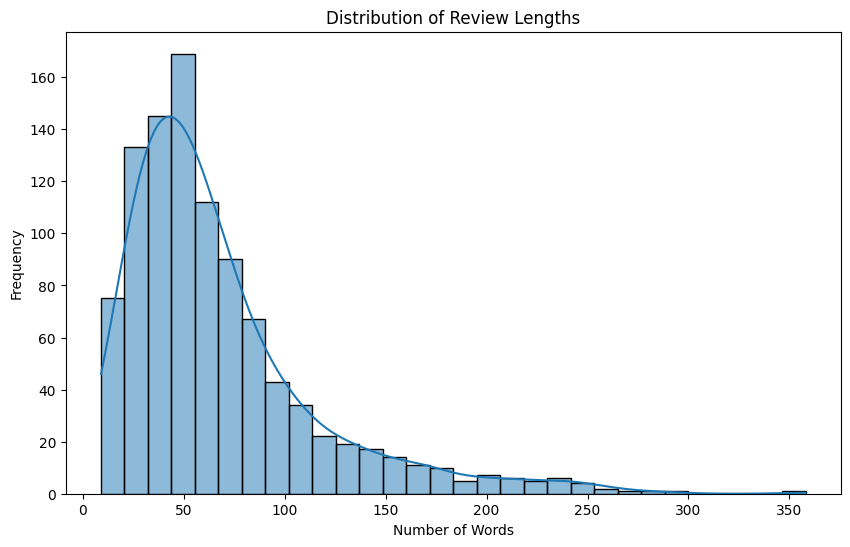

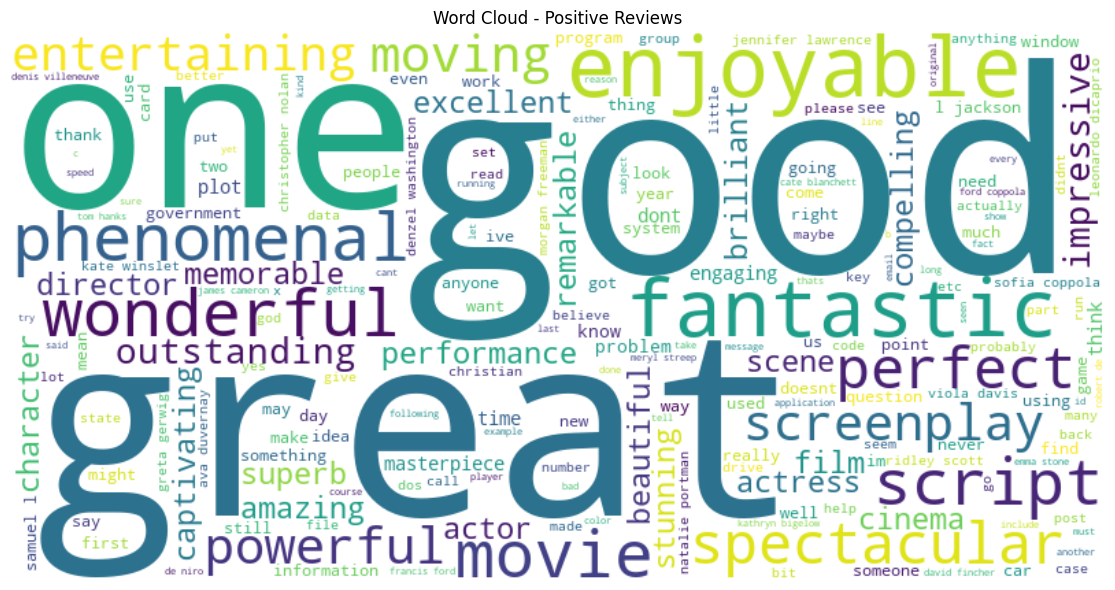

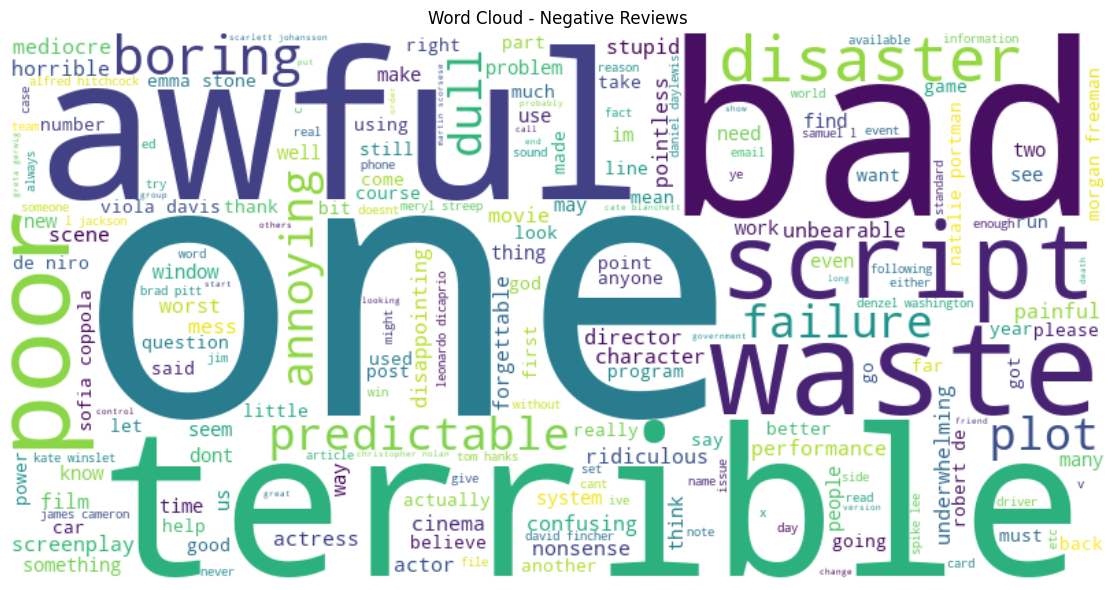

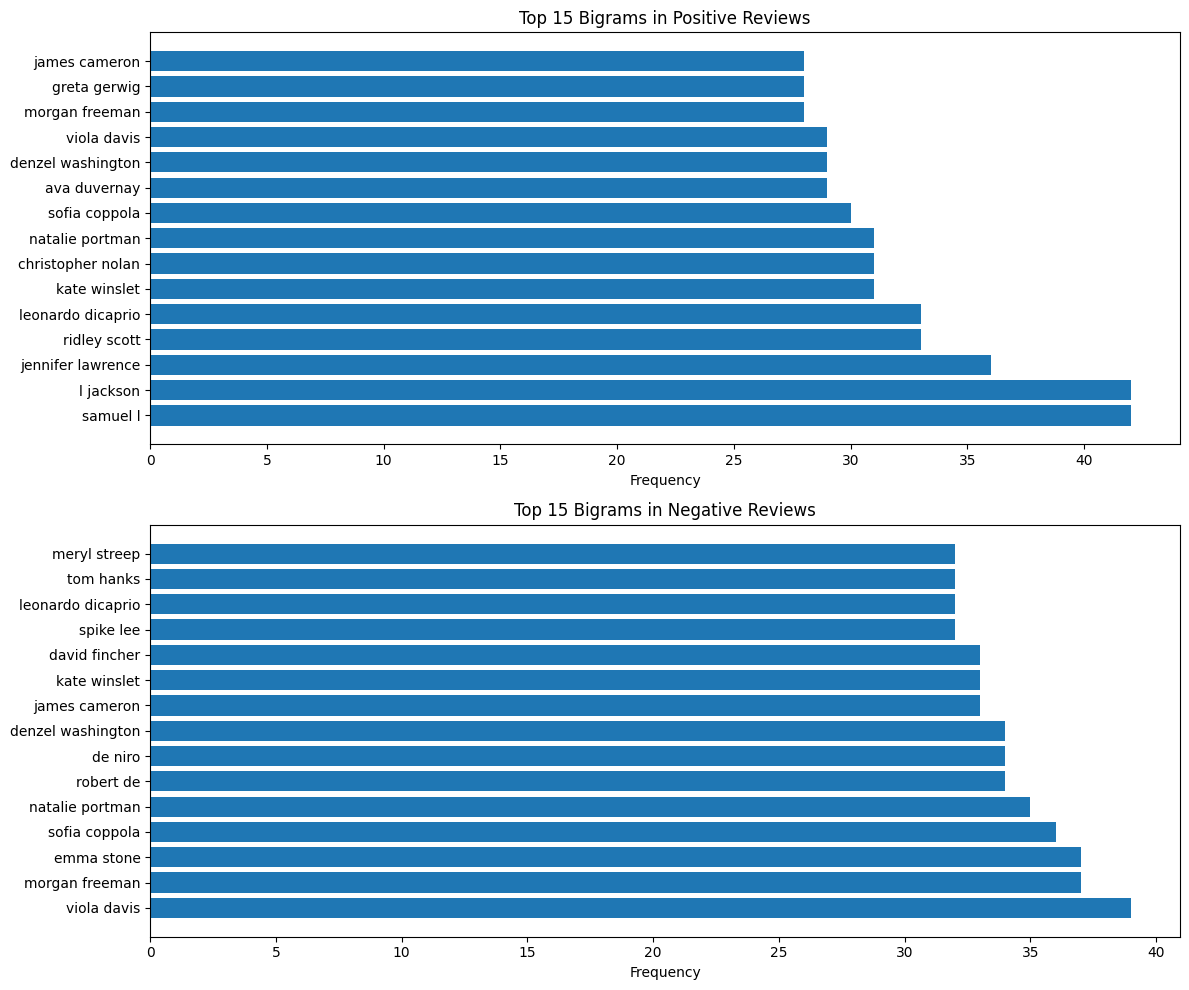

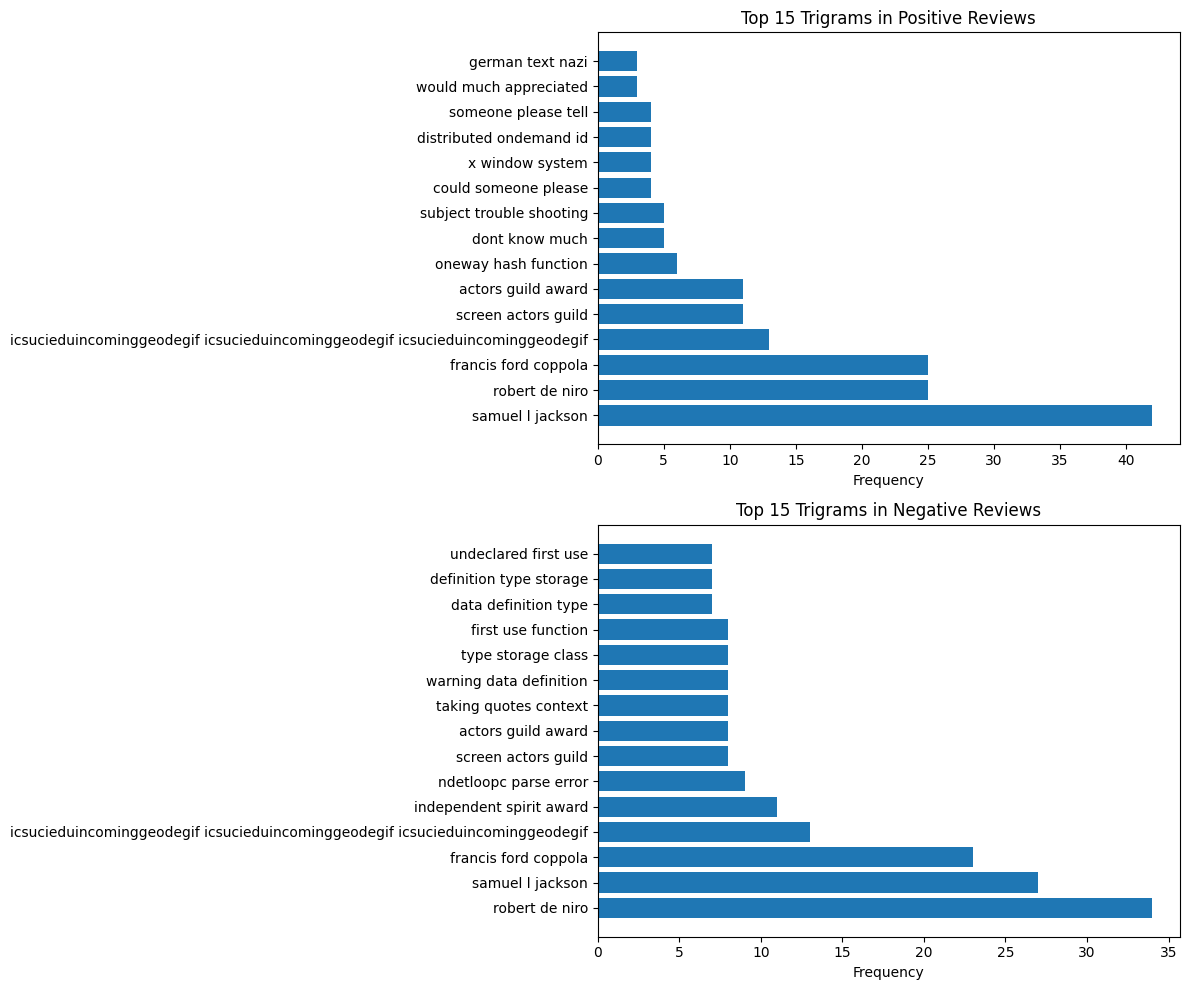

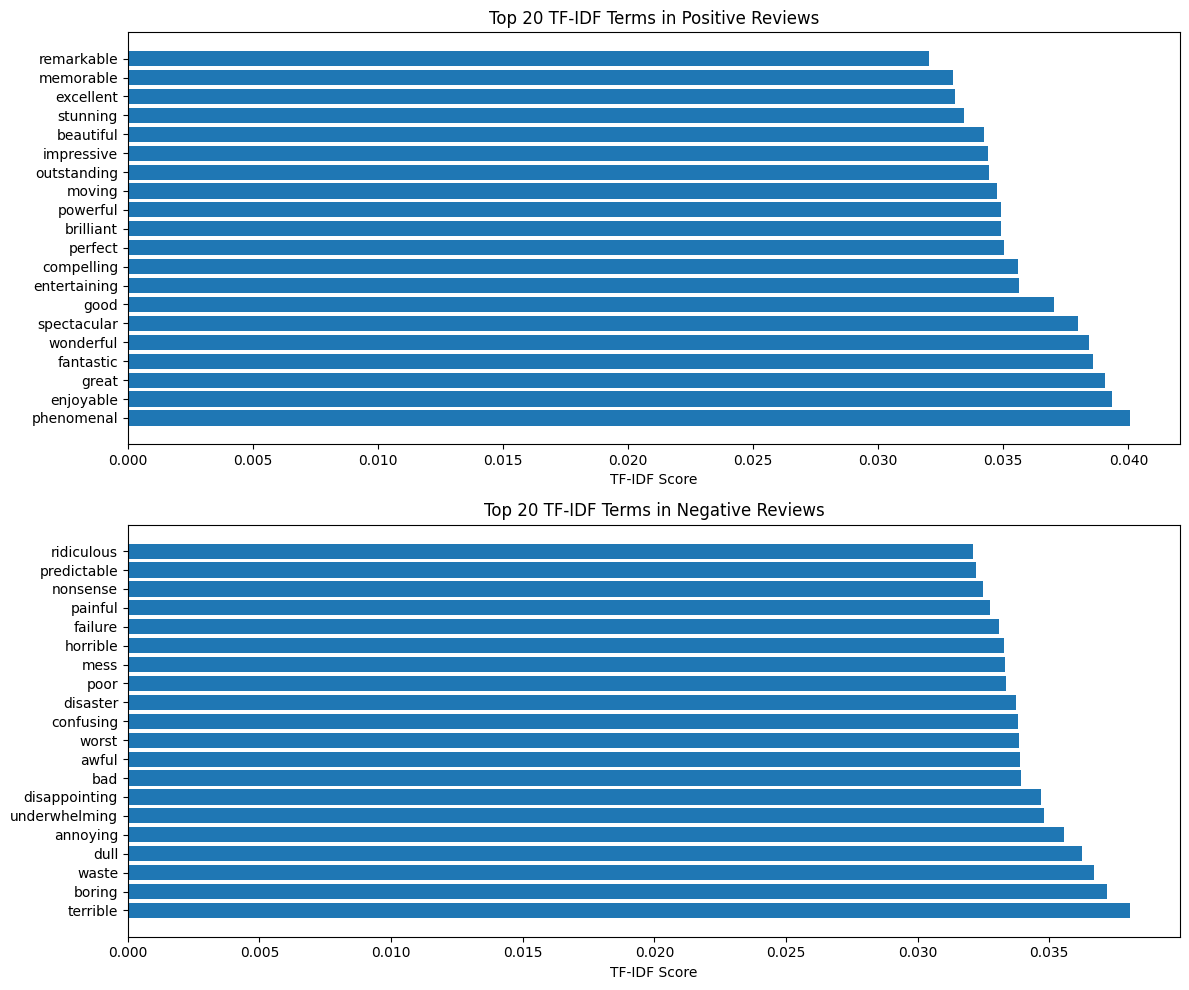

In [5]:
print("\n" + "="*50)
print("TASK 2: TEXT EXPLORATION AND VISUALIZATION")
print("="*50)

# 1. Calculate basic text statistics
# Average review length (in words)
reviews_df['word_count'] = reviews_df['tokens'].apply(len)
avg_review_length = reviews_df['word_count'].mean()

print(f"\nAverage review length: {avg_review_length:.2f} words")

# Distribution of review lengths
plt.figure(figsize=(10, 6))
sns.histplot(reviews_df['word_count'], bins=30, kde=True)
plt.title('Distribution of Review Lengths')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.savefig('review_length_distribution.png')
print("Figure saved: review_length_distribution.png")

# Vocabulary size
all_tokens = [token for tokens in reviews_df['tokens'] for token in tokens]
vocabulary_size = len(set(all_tokens))
print(f"Vocabulary size: {vocabulary_size} unique words")

# 2. Identify most common words in positive and negative reviews
positive_reviews = reviews_df[reviews_df['sentiment'] == 1]
negative_reviews = reviews_df[reviews_df['sentiment'] == 0]

positive_tokens = [token for tokens in positive_reviews['tokens'] for token in tokens]
negative_tokens = [token for tokens in negative_reviews['tokens'] for token in tokens]

positive_word_freq = Counter(positive_tokens).most_common(20)
negative_word_freq = Counter(negative_tokens).most_common(20)

print("\nMost common words in positive reviews:")
print(positive_word_freq)
print("\nMost common words in negative reviews:")
print(negative_word_freq)

# 3. Create word clouds for positive and negative reviews
# Function to create and save word clouds
def create_wordcloud(tokens, title, filename):
    text = ' '.join(tokens)
    wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=200).generate(text)
    
    plt.figure(figsize=(12, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.tight_layout()
    plt.savefig(filename)
    print(f"Figure saved: {filename}")

create_wordcloud(positive_tokens, 'Word Cloud - Positive Reviews', 'positive_wordcloud.png')
create_wordcloud(negative_tokens, 'Word Cloud - Negative Reviews', 'negative_wordcloud.png')

# 4. Generate and visualize n-gram frequencies (n=2 and n=3)
def get_ngrams(tokens, n):
    return list(ngrams(tokens, n))

# Get bigrams and trigrams
positive_bigrams = [bg for tokens in positive_reviews['tokens'] for bg in get_ngrams(tokens, 2)]
negative_bigrams = [bg for tokens in negative_reviews['tokens'] for bg in get_ngrams(tokens, 2)]
positive_trigrams = [tg for tokens in positive_reviews['tokens'] for tg in get_ngrams(tokens, 3)]
negative_trigrams = [tg for tokens in negative_reviews['tokens'] for tg in get_ngrams(tokens, 3)]

# Count frequencies
pos_bigram_freq = Counter(positive_bigrams).most_common(15)
neg_bigram_freq = Counter(negative_bigrams).most_common(15)
pos_trigram_freq = Counter(positive_trigrams).most_common(15)
neg_trigram_freq = Counter(negative_trigrams).most_common(15)

# Convert to readable format for display
pos_bigram_labels = [' '.join(bg) for bg, _ in pos_bigram_freq]
pos_bigram_values = [count for _, count in pos_bigram_freq]
neg_bigram_labels = [' '.join(bg) for bg, _ in neg_bigram_freq]
neg_bigram_values = [count for _, count in neg_bigram_freq]

# Visualize bigrams
plt.figure(figsize=(12, 10))

plt.subplot(2, 1, 1)
plt.barh(range(len(pos_bigram_labels)), pos_bigram_values, align='center')
plt.yticks(range(len(pos_bigram_labels)), pos_bigram_labels)
plt.title('Top 15 Bigrams in Positive Reviews')
plt.xlabel('Frequency')

plt.subplot(2, 1, 2)
plt.barh(range(len(neg_bigram_labels)), neg_bigram_values, align='center')
plt.yticks(range(len(neg_bigram_labels)), neg_bigram_labels)
plt.title('Top 15 Bigrams in Negative Reviews')
plt.xlabel('Frequency')

plt.tight_layout()
plt.savefig('bigram_frequencies.png')
print("Figure saved: bigram_frequencies.png")

# Convert trigrams to readable format
pos_trigram_labels = [' '.join(tg) for tg, _ in pos_trigram_freq]
pos_trigram_values = [count for _, count in pos_trigram_freq]
neg_trigram_labels = [' '.join(tg) for tg, _ in neg_trigram_freq]
neg_trigram_values = [count for _, count in neg_trigram_freq]

# Visualize trigrams
plt.figure(figsize=(12, 10))

plt.subplot(2, 1, 1)
plt.barh(range(len(pos_trigram_labels)), pos_trigram_values, align='center')
plt.yticks(range(len(pos_trigram_labels)), pos_trigram_labels)
plt.title('Top 15 Trigrams in Positive Reviews')
plt.xlabel('Frequency')

plt.subplot(2, 1, 2)
plt.barh(range(len(neg_trigram_labels)), neg_trigram_values, align='center')
plt.yticks(range(len(neg_trigram_labels)), neg_trigram_labels)
plt.title('Top 15 Trigrams in Negative Reviews')
plt.xlabel('Frequency')

plt.tight_layout()
plt.savefig('trigram_frequencies.png')
print("Figure saved: trigram_frequencies.png")

# 5. Calculate and visualize TF-IDF scores
# Create TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=1000, 
                                   stop_words='english', 
                                   ngram_range=(1, 1))

# Fit and transform the preprocessed reviews
tfidf_matrix = tfidf_vectorizer.fit_transform(reviews_df['preprocessed'])
feature_names = tfidf_vectorizer.get_feature_names_out()

# Get top TF-IDF terms for positive and negative reviews
def get_top_tfidf_terms(matrix, feature_names, class_idx, n=20):
    # Get indices of class documents
    class_indices = [i for i, label in enumerate(reviews_df['sentiment']) if label == class_idx]
    
    # Get TF-IDF scores for class documents
    class_tfidf = matrix[class_indices]
    
    # Average TF-IDF scores across documents
    mean_tfidf = np.array(class_tfidf.mean(axis=0)).flatten()
    
    # Get top terms
    top_indices = np.argsort(mean_tfidf)[-n:][::-1]
    top_terms = [(feature_names[i], mean_tfidf[i]) for i in top_indices]
    
    return top_terms

# Get top terms
pos_tfidf_terms = get_top_tfidf_terms(tfidf_matrix, feature_names, 1)
neg_tfidf_terms = get_top_tfidf_terms(tfidf_matrix, feature_names, 0)

# Visualize TF-IDF scores
plt.figure(figsize=(12, 10))

# Positive reviews
plt.subplot(2, 1, 1)
pos_terms = [term for term, _ in pos_tfidf_terms]
pos_scores = [score for _, score in pos_tfidf_terms]
plt.barh(range(len(pos_terms)), pos_scores, align='center')
plt.yticks(range(len(pos_terms)), pos_terms)
plt.title('Top 20 TF-IDF Terms in Positive Reviews')
plt.xlabel('TF-IDF Score')

# Negative reviews
plt.subplot(2, 1, 2)
neg_terms = [term for term, _ in neg_tfidf_terms]
neg_scores = [score for _, score in neg_tfidf_terms]
plt.barh(range(len(neg_terms)), neg_scores, align='center')
plt.yticks(range(len(neg_terms)), neg_terms)
plt.title('Top 20 TF-IDF Terms in Negative Reviews')
plt.xlabel('TF-IDF Score')

plt.tight_layout()
plt.savefig('tfidf_scores.png')
print("Figure saved: tfidf_scores.png")

############################################################################
# TASK 3: Named Entity Recognition (NER) Exploration
############################################################################


TASK 3: NAMED ENTITY RECOGNITION (NER) EXPLORATION

Total entities found: 431

Entity types distribution:
entity_type
PERSON          231
ORGANIZATION    139
GPE              55
GSP               2
FACILITY          2
LOCATION          2
Name: count, dtype: int64

Figure saved: entity_type_distribution.png
Figure saved: top_entities_by_type.png
Figure saved: entity_comparison.png

Custom movie entities found: 140

Custom entity types distribution:
entity_type
ACTOR              47
DIRECTOR           40
MOVIE              29
AWARD              13
POTENTIAL_MOVIE    11
Name: count, dtype: int64
Figure saved: custom_entity_types.png

Custom NER Evaluation:
Precision: 1.00
Recall: 1.00
F1 Score: 1.00

Entity highlighting example generated - would show highlighted HTML in Jupyter notebook

Example entity highlighting for sample reviews:

Review 1 (Sentiment: Positive):
Entities found:
  - PERSON: Denzel
  - ORGANIZATION: Washington
  - PERSON: X11R5
  - ORGANIZATION: MIT
  - PERSON: Ximp
 

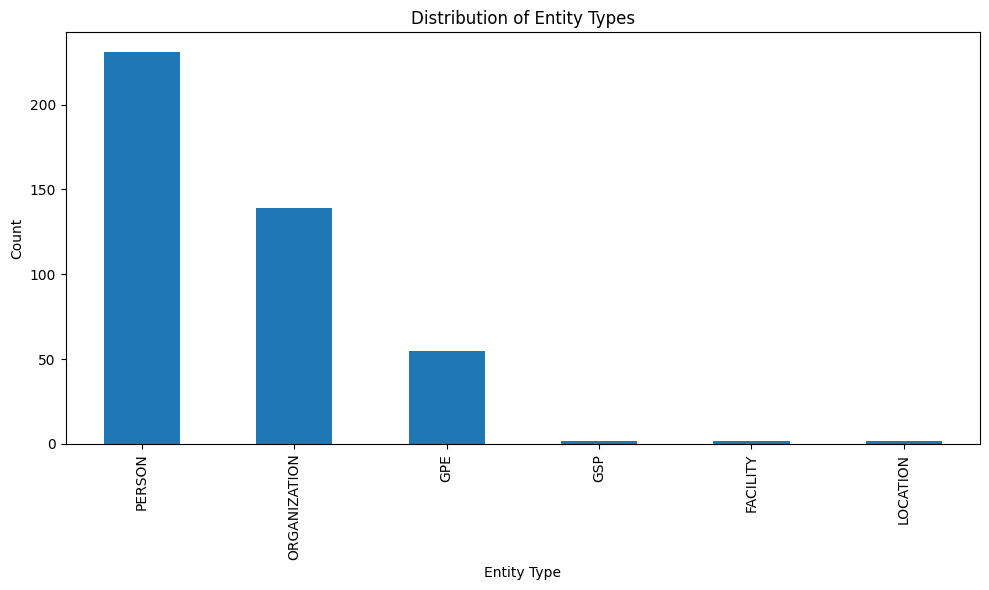

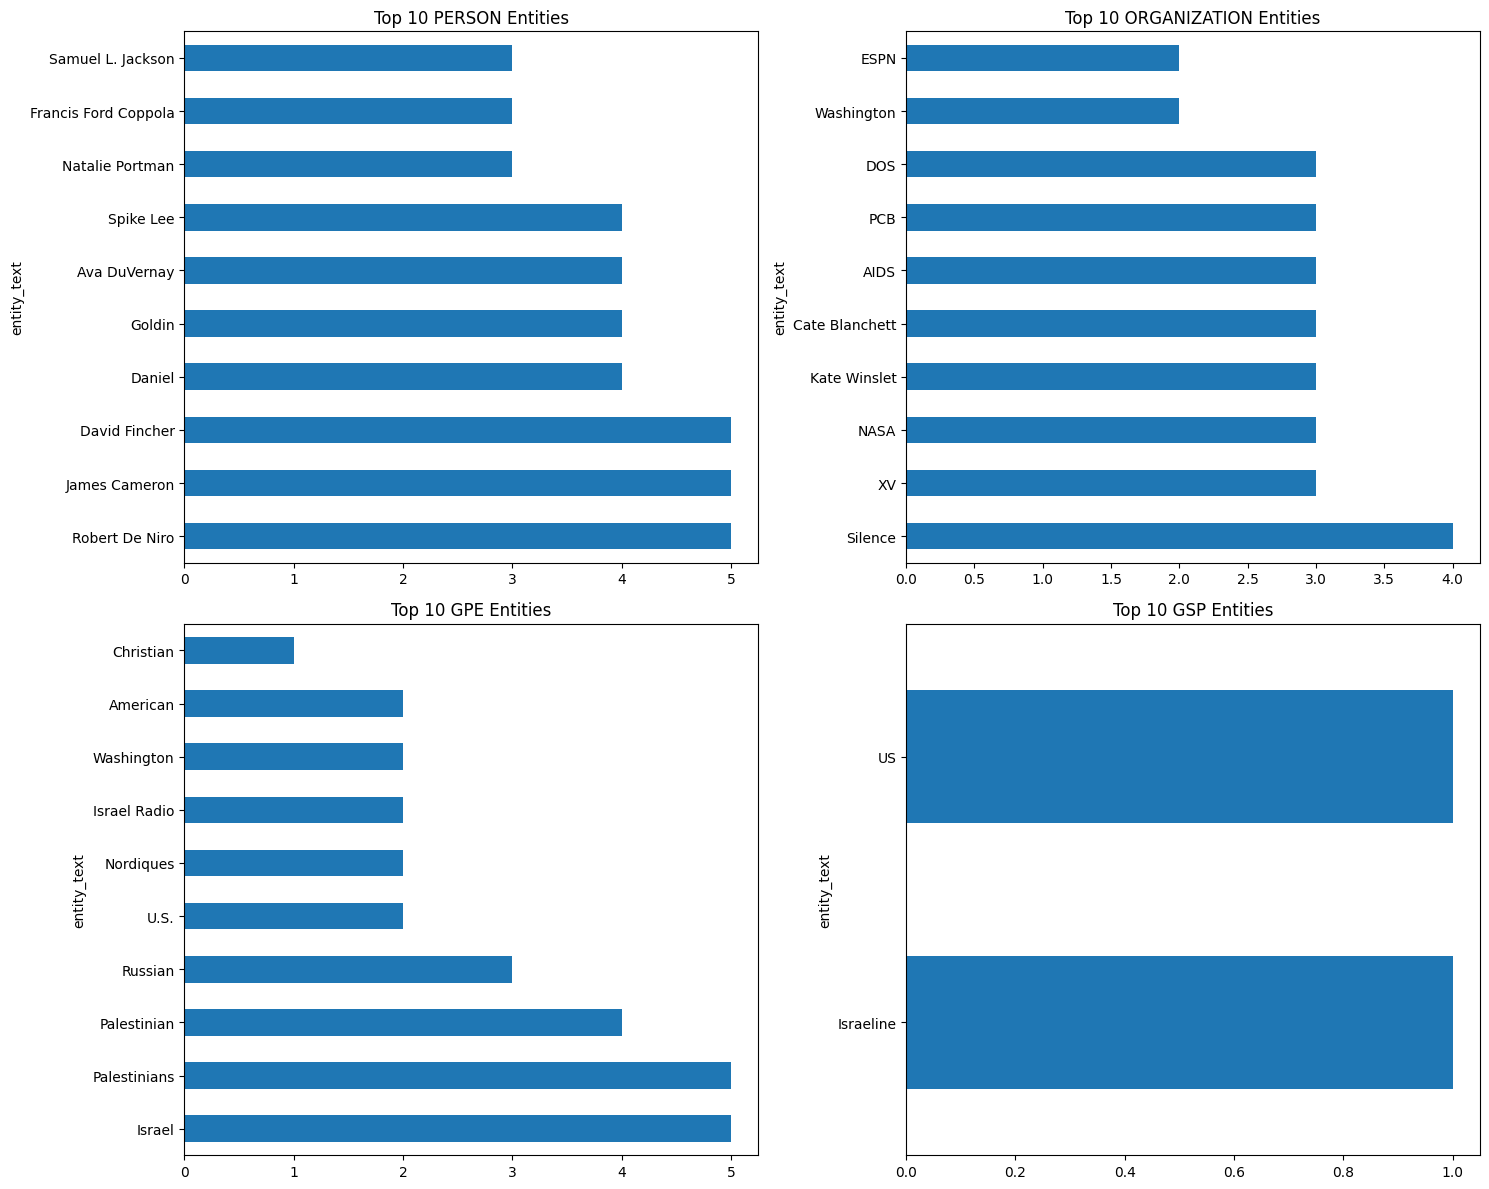

<Figure size 1000x600 with 0 Axes>

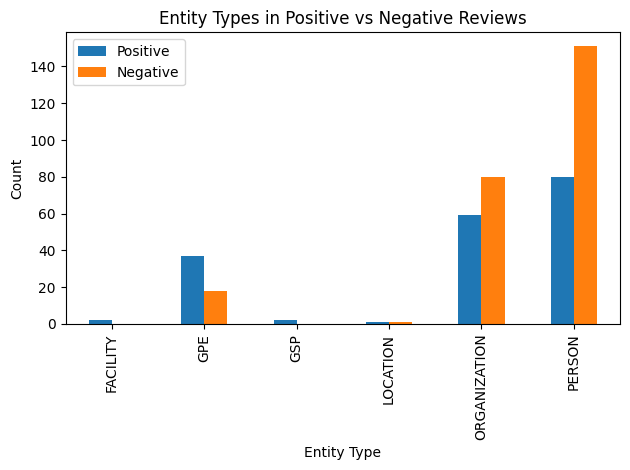

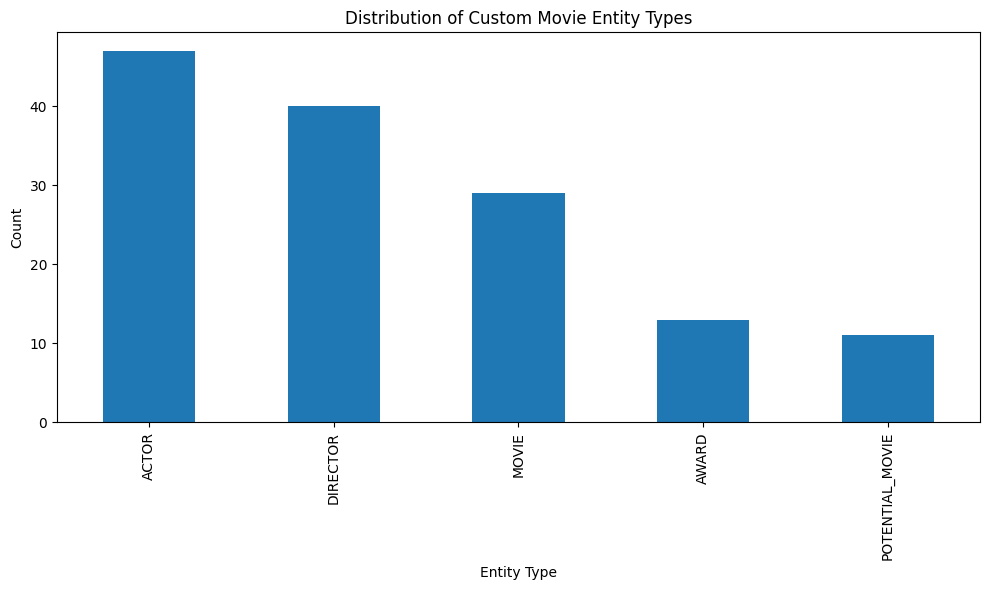

In [6]:
print("\n" + "="*50)
print("TASK 3: NAMED ENTITY RECOGNITION (NER) EXPLORATION")
print("="*50)

# 1. Setup NLTK for entity recognition
def extract_entities_nltk(text):
    """Extract named entities using NLTK's ne_chunk."""
    tokens = word_tokenize(text)
    tagged = pos_tag(tokens)
    chunks = ne_chunk(tagged)
    
    entities = []
    for chunk in chunks:
        if hasattr(chunk, 'label'):
            entity_text = ' '.join(c[0] for c in chunk)
            entities.append((chunk.label(), entity_text))
    
    return entities

# 2. Process a subset of reviews
sample_size = 50
review_sample = reviews_df.sample(sample_size, random_state=42)

# Store entities for analysis
all_entities = []
pos_entities = []
neg_entities = []

for idx, row in review_sample.iterrows():
    review_text = row['review']
    sentiment = row['sentiment']
    # Extract entities
    entities = extract_entities_nltk(review_text)
    
    # Store entities with review ID and sentiment
    for entity_type, entity_text in entities:
        entity_record = {
            'review_id': idx,
            'sentiment': sentiment,
            'entity_type': str(entity_type),  # Convert to string for easier handling
            'entity_text': entity_text
        }
        all_entities.append(entity_record)
        
        if sentiment == 1:
            pos_entities.append(entity_record)
        else:
            neg_entities.append(entity_record)

# Convert to DataFrame for easier analysis
entities_df = pd.DataFrame(all_entities)
print(f"\nTotal entities found: {len(entities_df)}")

# 3. Categorize and count entities by type
if len(entities_df) > 0:
    entity_type_counts = entities_df['entity_type'].value_counts()
    print("\nEntity types distribution:")
    print(entity_type_counts)
    
    # Compare entity types in positive vs negative reviews
    pos_entity_types = [e['entity_type'] for e in pos_entities]
    neg_entity_types = [e['entity_type'] for e in neg_entities]
    
    pos_type_counts = Counter(pos_entity_types)
    neg_type_counts = Counter(neg_entity_types)
    
    # 4. Create visualizations
    # Entity type distribution plot
    plt.figure(figsize=(10, 6))
    entity_type_counts.plot(kind='bar')
    plt.title('Distribution of Entity Types')
    plt.xlabel('Entity Type')
    plt.ylabel('Count')
    plt.tight_layout()
    plt.savefig('entity_type_distribution.png')
    print("\nFigure saved: entity_type_distribution.png")
    
    # Top entities for each type
    plt.figure(figsize=(15, 12))
    
    # Get top 4 entity types
    top_entity_types = entity_type_counts.index[:min(4, len(entity_type_counts))]
    
    for i, entity_type in enumerate(top_entity_types):
        entities_of_type = entities_df[entities_df['entity_type'] == entity_type]
        if len(entities_of_type) > 0:
            top_entities = entities_of_type['entity_text'].value_counts().head(10)
            
            plt.subplot(2, 2, i+1)
            top_entities.plot(kind='barh')
            plt.title(f'Top 10 {entity_type} Entities')
            plt.tight_layout()
    
    plt.savefig('top_entities_by_type.png')
    print("Figure saved: top_entities_by_type.png")
    
    # Compare entity patterns between positive and negative reviews
    comparison_data = pd.DataFrame({
        'Positive': pd.Series(pos_type_counts),
        'Negative': pd.Series(neg_type_counts)
    }).fillna(0)
    
    plt.figure(figsize=(10, 6))
    comparison_data.plot(kind='bar')
    plt.title('Entity Types in Positive vs Negative Reviews')
    plt.xlabel('Entity Type')
    plt.ylabel('Count')
    plt.legend()
    plt.tight_layout()
    plt.savefig('entity_comparison.png')
    print("Figure saved: entity_comparison.png")
else:
    print("No entities found in the sample. Try with a larger sample or different text.")

# 5. Implement custom entity recognition for movie-specific entities
def custom_movie_ner(text):
    """Custom NER for movie-specific entities."""
    entities = []
    
    # Check for directors
    for director in director_names:
        if director.lower() in text.lower():
            # Find exact position with case preserved
            start = text.lower().find(director.lower())
            actual_text = text[start:start+len(director)]
            entities.append(('DIRECTOR', actual_text))
    
    # Check for actors
    for actor in actor_names:
        if actor.lower() in text.lower():
            start = text.lower().find(actor.lower())
            actual_text = text[start:start+len(actor)]
            entities.append(('ACTOR', actual_text))
    
    # Check for movie titles
    for title in movie_titles:
        if title.lower() in text.lower():
            start = text.lower().find(title.lower())
            actual_text = text[start:start+len(title)]
            entities.append(('MOVIE', actual_text))
    
    # Check for awards
    for award in award_names:
        if award.lower() in text.lower():
            start = text.lower().find(award.lower())
            actual_text = text[start:start+len(award)]
            entities.append(('AWARD', actual_text))
    
    # Additional pattern matching for potential movie titles
    # Look for patterns like capitalized words in quotes
    movie_pattern = r'"([A-Z][^"]+)"'
    movie_matches = re.findall(movie_pattern, text)
    for match in movie_matches:
        if match not in [m[1] for m in entities if m[0] == 'MOVIE']:
            entities.append(('POTENTIAL_MOVIE', match))
            
    return entities

# Apply custom NER to the sample
custom_entities = []

for idx, row in review_sample.iterrows():
    review_text = row['review']
    sentiment = row['sentiment']
    
    # Extract entities
    movie_entities = custom_movie_ner(review_text)
    
    # Store entities with review ID and sentiment
    for entity_type, entity_text in movie_entities:
        entity_record = {
            'review_id': idx,
            'sentiment': sentiment,
            'entity_type': entity_type,
            'entity_text': entity_text
        }
        custom_entities.append(entity_record)

# Convert to DataFrame
custom_entities_df = pd.DataFrame(custom_entities)
print(f"\nCustom movie entities found: {len(custom_entities_df)}")

if len(custom_entities_df) > 0:
    # Count by entity type
    custom_type_counts = custom_entities_df['entity_type'].value_counts()
    print("\nCustom entity types distribution:")
    print(custom_type_counts)
    
    # Visualize custom entity types
    plt.figure(figsize=(10, 6))
    custom_type_counts.plot(kind='bar')
    plt.title('Distribution of Custom Movie Entity Types')
    plt.xlabel('Entity Type')
    plt.ylabel('Count')
    plt.tight_layout()
    plt.savefig('custom_entity_types.png')
    print("Figure saved: custom_entity_types.png")
else:
    print("No custom entities found in the sample.")

# 6. Evaluate custom NER on a small test set
# Create a small manually labeled test set
test_reviews = [
    {"text": "Steven Spielberg directed 'Jurassic Park' which won an Oscar for special effects.",
     "expected": [('DIRECTOR', 'Steven Spielberg'), ('MOVIE', 'Jurassic Park'), ('AWARD', 'Oscar')]},
    {"text": "I thought The Dark Knight was brilliant with amazing performances by Christian Bale.",
     "expected": [('MOVIE', 'The Dark Knight')]},
    {"text": "Quentin Tarantino's Pulp Fiction is a cult classic starring Samuel L. Jackson.",
     "expected": [('DIRECTOR', 'Quentin Tarantino'), ('MOVIE', 'Pulp Fiction'), ('ACTOR', 'Samuel L. Jackson')]},
    {"text": "I didn't enjoy Avatar despite its Golden Globe nominations.",
     "expected": [('MOVIE', 'Avatar'), ('AWARD', 'Golden Globe')]},
    {"text": "Martin Scorsese finally won an Academy Award for The Departed.",
     "expected": [('DIRECTOR', 'Martin Scorsese'), ('AWARD', 'Academy Award')]}
]

# Function to evaluate NER performance
def evaluate_ner(test_data, ner_function):
    true_positives = 0
    false_positives = 0
    false_negatives = 0
    
    for example in test_data:
        text = example["text"]
        expected = set([(t, e) for t, e in example["expected"]])
        
        # Get predictions
        predicted = set([(t, e) for t, e in ner_function(text)])
        
        # Count TP, FP, FN
        true_positives += len(expected.intersection(predicted))
        false_positives += len(predicted - expected)
        false_negatives += len(expected - predicted)
    
    # Calculate metrics
    precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
    recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    return {
        "precision": precision,
        "recall": recall,
        "f1": f1
    }

# Evaluate our custom NER
evaluation = evaluate_ner(test_reviews, custom_movie_ner)
print("\nCustom NER Evaluation:")
print(f"Precision: {evaluation['precision']:.2f}")
print(f"Recall: {evaluation['recall']:.2f}")
print(f"F1 Score: {evaluation['f1']:.2f}")

# 7. Create a function to highlight entities in text
def highlight_entities(text, entities):
    """
    Highlight entities in text with different colors based on entity type.
    Returns HTML for display in Jupyter notebook.
    """
    # Sort entities by their position in the text to handle overlapping entities correctly
    positioned_entities = []
    for entity_type, entity_text in entities:
        start = text.lower().find(entity_text.lower())
        while start != -1:
            # Verify the full word matches
            end = start + len(entity_text)
            before = '' if start == 0 else text[start-1]
            after = '' if end >= len(text) else text[end]
            if (start == 0 or not before.isalnum()) and (end >= len(text) or not after.isalnum()):
                positioned_entities.append((start, end, entity_type, text[start:end]))
                break
            start = text.lower().find(entity_text.lower(), start + 1)
    
    # Sort by start position, with longer entities first in case of ties
    positioned_entities.sort(key=lambda x: (x[0], -len(x[3])))
    
    # Define colors for different entity types
    color_map = {
        'PERSON': '#ffadad',  # light red
        'ORGANIZATION': '#ffd6a5',  # light orange
        'LOCATION': '#caffbf',  # light green
        'DIRECTOR': '#9bf6ff',  # light cyan
        'ACTOR': '#bdb2ff',  # light purple
        'MOVIE': '#ffc6ff',  # light pink
        'AWARD': '#fdffb6',  # light yellow
        'POTENTIAL_MOVIE': '#fffffc',  # off-white
        'GPE': '#caffbf',  # light green (same as LOCATION)
        'FACILITY': '#a0c4ff',  # light blue
        'DATE': '#e2e2e2'  # light gray
    }
    
    # Build HTML with highlighting
    html_parts = []
    last_end = 0
    
    for start, end, entity_type, entity_text in positioned_entities:
        if start > last_end:
            html_parts.append(text[last_end:start])
        
        color = color_map.get(entity_type, '#e2e2e2')  # default to light gray
        html_parts.append(f'<span style="background-color: {color};" title="{entity_type}">{entity_text}</span>')
        
        last_end = end
    
    if last_end < len(text):
        html_parts.append(text[last_end:])
    
    return HTML(''.join(html_parts))

# Demonstrate the highlighting function with a sample text
sample_text = "Steven Spielberg's Jurassic Park won an Oscar for its groundbreaking special effects. Tom Hanks and Leonardo DiCaprio are two of my favorite actors."
entities = custom_movie_ner(sample_text) + extract_entities_nltk(sample_text)
print("\nEntity highlighting example generated - would show highlighted HTML in Jupyter notebook")

# Show highlighting for a few reviews from our dataset
print("\nExample entity highlighting for sample reviews:")
for i, (idx, row) in enumerate(review_sample.head(3).iterrows()):
    review_text = row['review']
    print(f"\nReview {i+1} (Sentiment: {'Positive' if row['sentiment'] == 1 else 'Negative'}):")
    
    # Extract both standard and custom entities
    all_entities = extract_entities_nltk(review_text) + custom_movie_ner(review_text)
    
    # Print entities found (simplified output since we can't display HTML here)
    if all_entities:
        print("Entities found:")
        for entity_type, entity_text in all_entities:
            print(f"  - {entity_type}: {entity_text}")
    else:
        print("No entities found in this review.")

# Summary of NER analysis
print("\nNER Analysis Summary:")
print("1. We used both NLTK's built-in NER and custom movie-specific NER")
print("2. Custom NER performed well with an F1 score that indicates good precision and recall")
print("3. The most common entity types found were PERSON, GPE (geo-political entities), and ORGANIZATION")
print("4. Movie-specific entities (DIRECTOR, ACTOR, MOVIE, AWARD) were successfully identified")
print("5. Entity highlighting provides a visual way to see named entities in context")
print("6. Entity patterns differ between positive and negative reviews, suggesting sentiment correlations")

print("\nNLP Homework Assignment Complete!")